In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.si_ae import SideInformationAutoEncoder
from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


In [3]:
config.H_target = 2* 0.3
config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.beta

500

In [4]:
class AverageMetric(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self, func,name):
        # If it's a partial, use func.func
        #         name = getattr(func,'func',func).__name__
        self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0) # batch size
        X_DEC_IND =1
        val = self.func(last_output[X_DEC_IND], last_target[0])
        self.val += last_target[0].size(0) * val.detach().cpu()

    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val/self.count)

In [5]:
config.use_si_flag = SiNetChannelIn.WithSideInformation
config.use_si_flag

<SiNetChannelIn.WithSideInformation: 6>

In [6]:
torch.__version__

'1.5.1'

In [7]:
si_autoencoder = SideInformationAutoEncoder(config.use_si_flag)
path = "../src/dsin/data"
pct= 1 #0.0005 #0.25

valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_FULL_stereo_val.txt"],pct=pct)
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_FULL_stereo_train.txt"],pct=pct)

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)

# ll = image_lists.label_from_func(lambda x: x)

tfms = None #get_transforms(do_flip=True, max_rotate=0.0)
batchsize = 1
data = (image_lists
        .label_from_func(lambda x: x)
        .transform(tfms, size=(336, 1224), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))
learn = Learner(data=data,
                     model=si_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(config.use_si_flag),
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])



In [8]:
learn.model.true_tuple_loss_false_just_out = True
learn.model.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.loss_func.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.fit(1, lr=0.0005,wd=0.00001)
learn.save('stereo-baseline-ae-for-si1')
learn.fit(1, lr=0.0005,wd=0.00001)
learn.save('stereo-baseline-ae-for-si2')

epoch,train_loss,valid_loss,MS_SSIM,time
0,263.800995,250.962158,4004.069092,4:02:29


epoch,train_loss,valid_loss,MS_SSIM,time


KeyboardInterrupt: 

In [13]:
learn.loss_func.soft_bit_entropy

tensor(0.9310, device='cuda:0', grad_fn=<MulBackward0>)

In [12]:
learn.loss_func.autoencoder_loss_value

tensor(469.7800, device='cuda:0', grad_fn=<MulBackward0>)

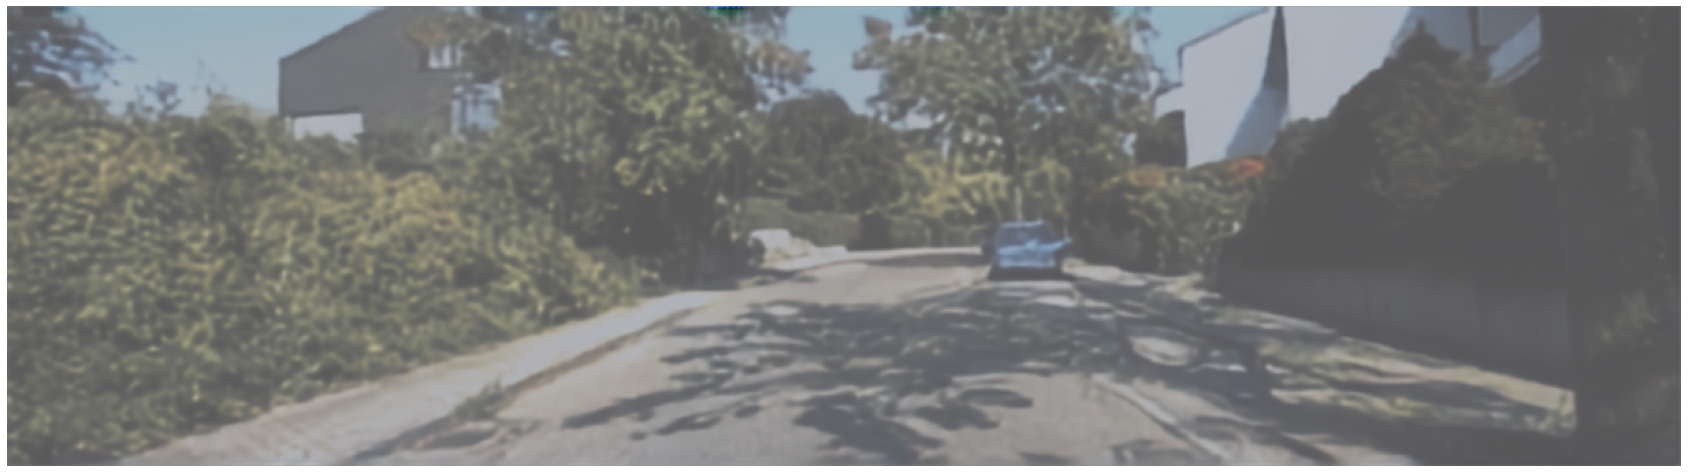

In [15]:

# # show_image(Image(learn.model.my_tuple[0][:,:50,:50]/255))
# # Image(learn.model.my_tuple[2].squeeze_().detach()/255.0)
mt = learn.model.my_tuple[3].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image((mt - mn)/(diff)),figsize=(30,30))
# # print(mn)

# torch.min(learn.model.my_tuple[2].squeeze_().detach())

In [ ]:
# learn.model.true_tuple_loss_false_just_out = False

# learn.show_results(figsize=(30,30))

In [16]:
learn.load('stereo-baseline-ae-for-si1')
learn.fit(1, lr=0.0005,wd=0.00001)
learn.save('stereo-baseline-ae-for-si2')

epoch,train_loss,valid_loss,MS_SSIM,time
0,252.397644,248.996155,4019.408203,4:01:46


In [17]:
learn.load('stereo-baseline-ae-for-si2')
learn.fit(1, lr=0.00005,wd=0.00001)
learn.save('stereo-baseline-ae-for-si3')

epoch,train_loss,valid_loss,MS_SSIM,time
0,251.709213,247.551605,4021.293701,4:02:37


In [18]:
learn.loss_func.soft_bit_entropy

tensor(0.9486, device='cuda:0')

In [19]:
learn.loss_func.autoencoder_loss_value

tensor(213.7899, device='cuda:0')

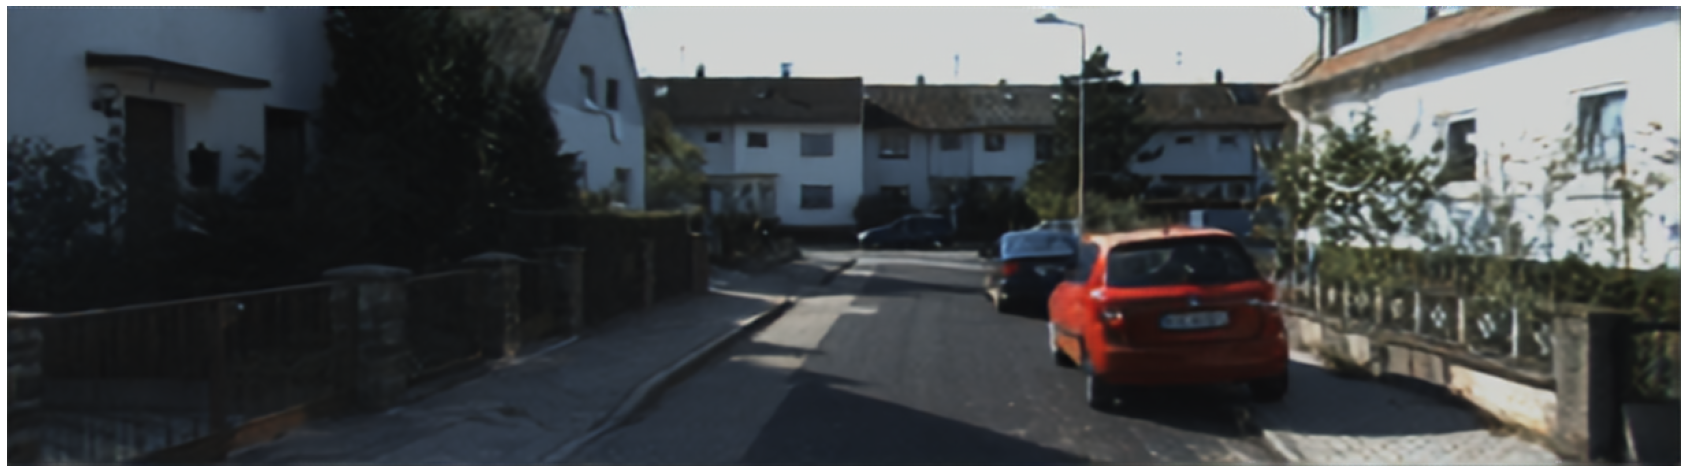

In [20]:

# # show_image(Image(learn.model.my_tuple[0][:,:50,:50]/255))
# # Image(learn.model.my_tuple[2].squeeze_().detach()/255.0)
mt = learn.model.my_tuple[3].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image((mt - mn)/(diff)),figsize=(30,30))